In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pyloric import simulate, create_prior, summary_stats
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from multiprocessing import Pool
import time
prior = create_prior()

/home/michael/anaconda3/envs/stg-energy/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [3]:
def my_simulator(params_with_seeds):
    p1 = create_prior()
    pars = p1.sample((1,))
    column_names = pars.columns

    parameter_set_pd = pd.DataFrame(
        np.asarray([params_with_seeds[:-1]]), columns=column_names
    )
    out_target = simulate(
        parameter_set_pd.loc[0],
        seed=int(params_with_seeds[-1]),
        dt=0.025,
        t_max=11000,
        temperature=283,
        noise_std=0.001,
        track_energy=True,
        energy_measure="current"
    )
    custom_stats = {
        "plateau_durations": True,
        "num_bursts": True,
        "num_spikes": True,
        "energies": True,
        "energies_per_burst": True,
        "energies_per_spike": True,
        "pyloric_like": True,
    }
    return summary_stats(out_target, stats_customization=custom_stats, t_burn_in=1000)

In [4]:
theta = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_circuit_parameters.pkl"
)
x = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_simulation_outputs.pkl"
)
seeds = np.load(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_seeds.npy"
)

In [5]:
data_np = theta.to_numpy()
params_with_seeds = np.concatenate((data_np, seeds[:, None]), axis=1)

In [ ]:
with Pool(16) as pool:
    start_time = time.time()
    data = pool.map(my_simulator, params_with_seeds)
    print("Simulation time", time.time() - start_time)

sims_out = pd.concat(data, ignore_index=True)

In [ ]:
sims_out.to_pickle("../../../results/energy_measure_comparison/posterior_only_kd.pkl")

In [7]:
sims_total = pd.read_pickle("../../../results/energy_measure_comparison/posterior_total.pkl")
sims_sodium = pd.read_pickle("../../../results/energy_measure_comparison/posterior_only_sodium.pkl")
sims_calcium = pd.read_pickle("../../../results/energy_measure_comparison/posterior_only_calcium.pkl")

In [89]:
e_power = np.sum(x["energies"].to_numpy(), axis=1) / 10 / 1000

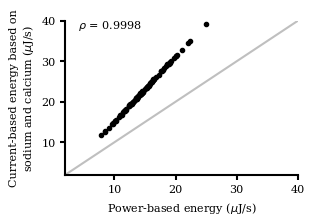

In [120]:
e_current = np.sum(sims_total["energies"].to_numpy(), axis=1)
rho = np.corrcoef(e_power, e_current)[0, 1]

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(3, 2))
    ax.scatter(e_power[:100], e_current[:100] / 10 / 1.6, c="k")  # / 10 because per second. / 1.6 because elementary charge is 1.6e-19 and ATP corresponds to 1.0e-19. No need for / 1000 because mS * mV = mu (compared to nano for mS * mV**2)
    ax.plot([2, 40], [2, 40], color="gray", alpha=0.5)
    ax.set_xlim([2, 40])
    ax.set_ylim([2, 40])
    ax.text(4, 38, r"$\rho$ = %.4f" %rho)
    ax.set_xlabel("Power-based energy ($\mu$J/s)")
    ax.set_ylabel("Current-based energy based on\nsodium and calcium ($\mu$J/s)")
    plt.savefig("../svg/panel_a_supp.svg", facecolor="None", transparent=True)

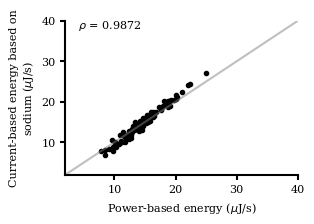

In [121]:
e_current = np.sum(sims_sodium["energies"].to_numpy(), axis=1)
rho = np.corrcoef(e_power, e_current)[0, 1]

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(3, 2))
    ax.scatter(e_power[:100], e_current[:100] / 10 / 1.6, c="k")
    ax.plot([2, 40], [2, 40], color="gray", alpha=0.5)
    ax.set_xlim([2, 40])
    ax.set_ylim([2, 40])
    ax.text(4, 38, r"$\rho$ = %.4f" %rho)
    ax.set_xlabel("Power-based energy ($\mu$J/s)")
    ax.set_ylabel("Current-based energy based on\nsodium ($\mu$J/s)")
    plt.savefig("../svg/panel_b_supp.svg", facecolor="None", transparent=True)

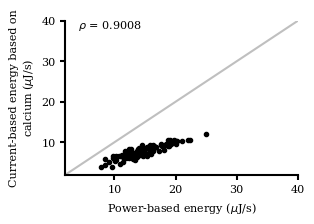

In [122]:
e_current = np.sum(sims_calcium["energies"].to_numpy(), axis=1)
rho = np.corrcoef(e_power, e_current)[0, 1]

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(3, 2))
    ax.scatter(e_power[:100], e_current[:100] / 10 / 1.6, c="k")
    ax.plot([2, 40], [2, 40], color="gray", alpha=0.5)
    ax.set_xlim([2, 40])
    ax.set_ylim([2, 40])
    ax.text(4, 38, r"$\rho$ = %.4f" %rho)
    ax.set_xlabel("Power-based energy ($\mu$J/s)")
    ax.set_ylabel("Current-based energy based on\ncalcium ($\mu$J/s)")
    plt.savefig("../svg/panel_c_supp.svg", facecolor="None", transparent=True)

In [123]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [125]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("20.3cm", "4.3cm",
           
    Panel(
          SVG("../svg/panel_a_supp.svg").move(0, 0),
          Text("a", -10, 2.0, **kwargs_text),
    ).move(10, 10),
    
    Panel(
          SVG("../svg/panel_b_supp.svg").move(0, 0),
          Text("b", -10, 2.0, **kwargs_text),
    ).move(260, 10),
           
    Panel(
          SVG("../svg/panel_c_supp.svg").move(0, 0),
          Text("c", -10, 2.0, **kwargs_text),
    ).move(510, 10),
)

!mkdir -p fig
f.save("../fig/fig1_appendix_measure_comparison.svg")
svg('../fig/fig1_appendix_measure_comparison.svg')